# First assignment - Andreas Samberg

Imports:

In [304]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams.update({'axes.grid':True,'grid.color':'black','grid.alpha':'0.25','grid.linestyle':'--'})
plt.rcParams.update({'font.size': 14})

from dstapi import DstApi
from fredapi import Fred
from helpers import f 

# Quick overview of the data

In [305]:
PRIS113 = DstApi('PRIS113')
prices = PRIS113.get_data
PRIS113.tablesummary(language='en')


Table PRIS113: Consumer price index by type and time
Last update: 2025-10-10T08:00:00


,variable name,# values,First value,First value label,Last value,Last value label,Time variable
0,TYPE,1,INDEKS,Consumer price index,INDEKS,Consumer price index,False
1,Tid,549,1980M01,1980M01,2025M09,2025M09,True


In [306]:
PRIS113.variable_levels('Tid',language='en')

,id,text
0,1980M01,1980M01
1,1980M02,1980M02
2,1980M03,1980M03
3,1980M04,1980M04
4,1980M05,1980M05
...,...,...
544,2025M05,2025M05
545,2025M06,2025M06
546,2025M07,2025M07
547,2025M08,2025M08


In [307]:
def convert_prices_to_datetime():
    Y = pd.to_datetime(prices["TID"], format='%YM%m')
    return Y
Y
# Looks a litle weird but the number of observations is the same so i assume
# everything is fine.

0     1980-01-01
138   1980-02-01
276   1980-03-01
412   1980-04-01
1     1980-05-01
         ...    
532   2025-05-01
252   2025-06-01
132   2025-07-01
128   2025-08-01
275   2025-09-01
Name: TID, Length: 549, dtype: datetime64[ns]

I check that all the data is there. I can not find my mistake if I have made one. The following code shows that all the observations are present:

In [308]:
# Verify that 1980 contains all 12 months
print(priser[priser["TID"].str.startswith("1980")])


                     TYPE      TID  INDHOLD  INDHOLD_rebased       date  \
138  Consumer price index  1980M01     33.0        31.904608 1980-01-01   
0    Consumer price index  1980M02     33.3        32.194650 1980-02-01   
276  Consumer price index  1980M03     33.8        32.678053 1980-03-01   
412  Consumer price index  1980M04     34.0        32.871415 1980-04-01   
139  Consumer price index  1980M05     34.5        33.354818 1980-05-01   
1    Consumer price index  1980M06     34.6        33.451499 1980-06-01   
277  Consumer price index  1980M07     35.2        34.031582 1980-07-01   
413  Consumer price index  1980M08     35.3        34.128263 1980-08-01   
140  Consumer price index  1980M09     35.5        34.321624 1980-09-01   
2    Consumer price index  1980M10     35.8        34.611666 1980-10-01   
278  Consumer price index  1980M11     36.1        34.901708 1980-11-01   
414  Consumer price index  1980M12     36.2        34.998389 1980-12-01   

     pct_change      pi_

In [309]:
params = {
    'table': 'PRIS113',
    'format': 'BULK', # semicolon separated file
    'lang': 'en',
    'variables': [
        {'code': 'TYPE', 'values': ['*']},
        {'code': 'Tid', 'values': ['*']},
        ]
    }

# b. download
priser = PRIS113.get_data(params=params)


# c. display
display(priser.head())
display(priser.info())


,TYPE,TID,INDHOLD
0,Consumer price index,1980M02,33.3
1,Consumer price index,1980M06,34.6
2,Consumer price index,1980M10,35.8
3,Consumer price index,1981M02,36.8
4,Consumer price index,1981M06,39.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 549 entries, 0 to 548
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   TYPE     549 non-null    object
 1   TID      549 non-null    object
 2   INDHOLD  549 non-null    object
dtypes: object(3)
memory usage: 13.0+ KB


None

# The consumer price index (CPI), Pt, indexed to 100 on average in 2020


In [310]:
# I transform 'INDHOLD' to numeric values

priser['INDHOLD'] = pd.to_numeric(priser['INDHOLD'])

# I take the mean of CPI in 2020
cpi_2020 = priser.loc[priser['TID'].str.contains('2020M'), 'INDHOLD'].mean()

print("Average CPI in 2020:", cpi_2020)

# make cpi_2020 equal to 100
priser['INDHOLD_rebased'] = priser['INDHOLD'] / cpi_2020 * 100


# Sort by date
priser = priser.sort_values("TID")
print(priser[["TID", "INDHOLD_rebased"]])


Average CPI in 2020: 103.43333333333332
         TID  INDHOLD_rebased
138  1980M01        31.904608
0    1980M02        32.194650
276  1980M03        32.678053
412  1980M04        32.871415
139  1980M05        33.354818
..       ...              ...
532  2025M05       116.403481
114  2025M06       116.693522
270  2025M07       118.433774
266  2025M08       117.660329
137  2025M09       117.563648

[549 rows x 2 columns]


In [311]:
# I make sure that the average of 2020 is 100 and that all the observations are present
mask = priser['TID'].astype(str).str.contains('2020M')
print(priser.loc[mask, ['TID', 'INDHOLD_rebased']])
# The average:
average_2020 = priser.loc[mask, 'INDHOLD_rebased'].mean()
print("Average CPI in 2020 (normalized):", average_2020)

         TID  INDHOLD_rebased
521  2020M01        99.581051
256  2020M02       100.161134
545  2020M03        99.871092
118  2020M04        99.774412
399  2020M05        99.677731
536  2020M06        99.774412
263  2020M07       100.547857
248  2020M08       100.161134
125  2020M09       100.064454
393  2020M10       100.257815
541  2020M11       100.161134
400  2020M12        99.967773
Average CPI in 2020 (normalized): 100.0


# Figure with index 2020 = 100

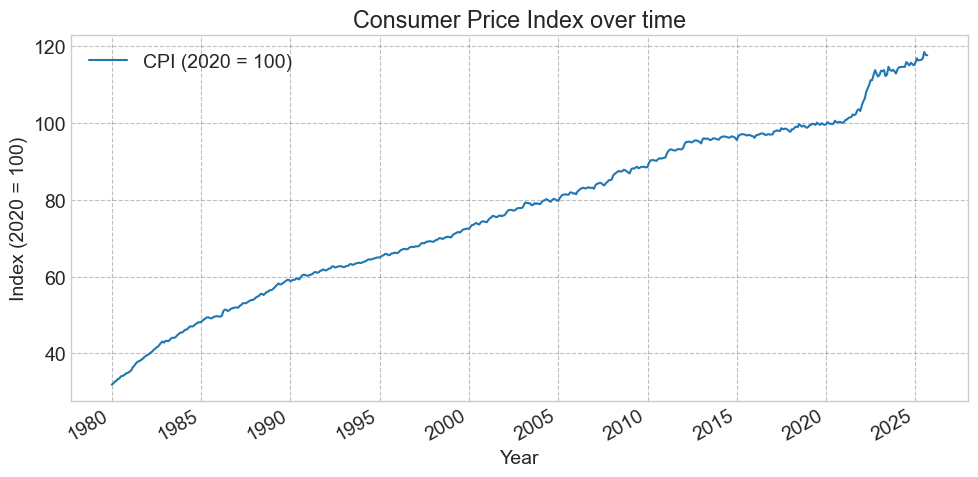

In [312]:

# 1) Make a real datetime from 'TID' like "2020M01"
priser["date"] = pd.to_datetime(priser["TID"], format="%YM%m")

# 2) Sort (important for a clean line)
priser = priser.sort_values("date")

# 3) Plot using the datetime axis
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(priser["date"], priser["INDHOLD_rebased"], label="CPI (2020 = 100)")

ax.set_title("Consumer Price Index over time")
ax.set_xlabel("Year")
ax.set_ylabel("Index (2020 = 100)")

# 4) Control the x-axis ticks (show more years)
ax.xaxis.set_major_locator(mdates.YearLocator(5))         
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
fig.autofmt_xdate()                                       

ax.legend()
plt.tight_layout()
plt.show()

# The month-to-month inflation rate

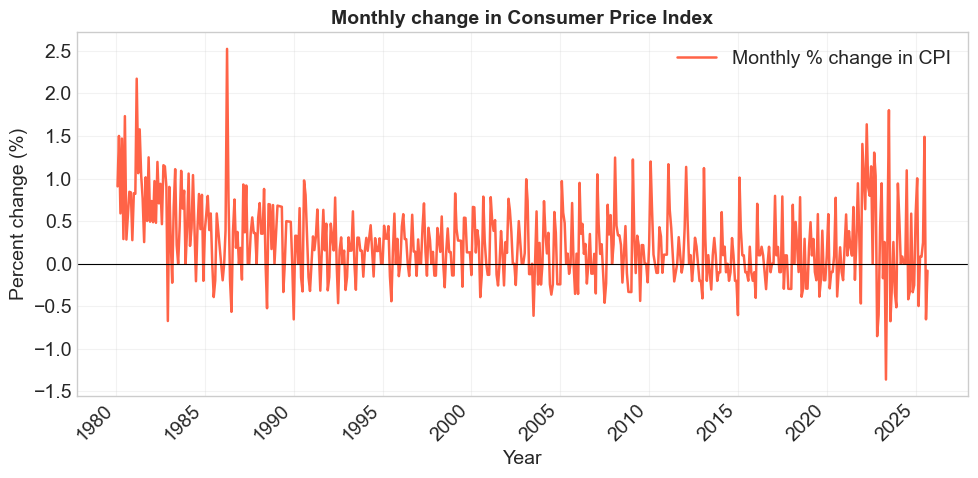

In [313]:
priser = priser.sort_values("date")  # sortér kronologisk
priser["pct_change"] = priser["INDHOLD"].pct_change() * 100

plt.style.use("seaborn-v0_8-whitegrid")
plt.figure(figsize=(10,5))

plt.plot(priser["date"], priser["pct_change"], color="tomato", linewidth=1.8, label="Monthly % change in CPI")

plt.title("Monthly change in Consumer Price Index", fontsize=14, weight="bold")
plt.xlabel("Year")
plt.ylabel("Percent change (%)")

# Show ticks every year
plt.gca().xaxis.set_major_locator(mdates.YearLocator(5))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
plt.xticks(rotation=45, ha="right")

plt.axhline(0, color="black", linewidth=0.8)  # horizontal line at 0%
plt.legend()
plt.tight_layout()
plt.show()

# The 12-month inflation rate

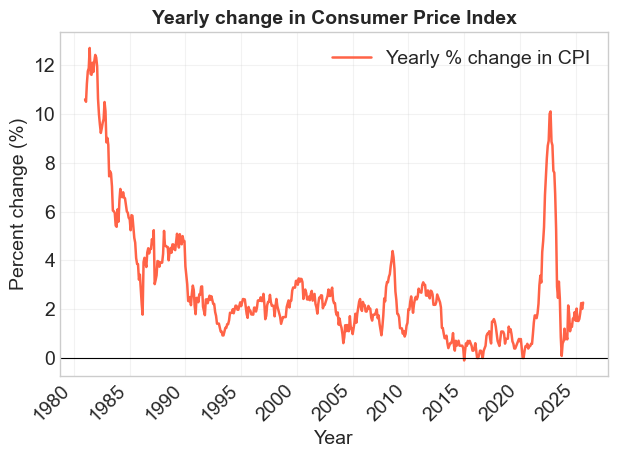

In [314]:
priser["pct_change"] = priser["INDHOLD"].pct_change(12) * 100

plt.plot(priser["date"], priser["pct_change"], color="tomato", linewidth=1.8, label="Yearly % change in CPI")

plt.title("Yearly change in Consumer Price Index", fontsize=14, weight="bold")
plt.xlabel("Year")
plt.ylabel("Percent change (%)")

# Show ticks every year
plt.gca().xaxis.set_major_locator(mdates.YearLocator(5))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
plt.xticks(rotation=45, ha="right")

plt.axhline(0, color="black", linewidth=0.8)  # horizontal line at 0%
plt.legend()
plt.tight_layout()
plt.show()

# 1.2 Instantaneous inflation - 1.2.1

In [315]:
# Since we are told that for a=0 we get the standard 12-month inflation rate, we can assume that T is = 12. 
T = 12
# Now that this parameter is defined, we can proceed to calculate kappa for different values of a and k.


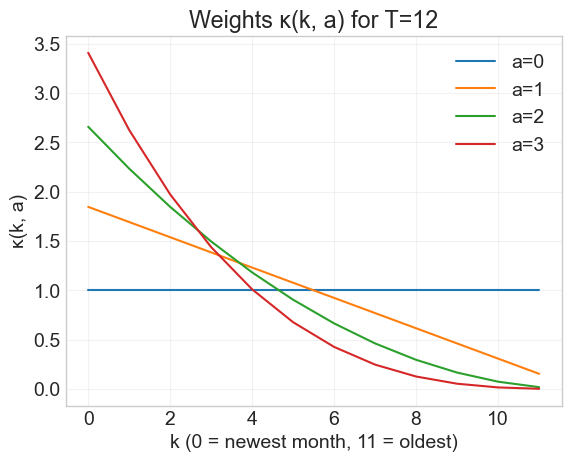

In [316]:
# weights kappa(k,a)
def kappa(k, a):
  ks = np.arange(T)
  denom = np.sum((T - ks)**a)
  return ((T - k)**a / denom) * T

# plot kappa for a in {0,1,2,3}
k_vals = np.arange(T)
for a in [0, 1, 2, 3]:
    plt.plot(k_vals, [kappa(k, a) for k in k_vals], label=f'a={a}')
plt.xlabel('k (0 = newest month, 11 = oldest)')
plt.ylabel('κ(k, a)')
plt.title('Weights κ(k, a) for T=12')
plt.legend(); plt.grid(True); plt.show()

# instantaneous inflation
def instantaneous_inflation_last_window(pi_last_12, a, T=12):
    ks = np.arange(T)
    w = (T - ks)**a
    w = w / w.sum()
    return np.prod((1.0 + np.asarray(pi_last_12))**w) - 1

# Example
def instantaneous_inflation_series(pi_series, a, T=12):
    pi_series = np.asarray(pi_series)
    out = np.full(pi_series.shape, np.nan, dtype=float)
    ks = np.arange(T)
    w = (T - ks)**a; w = w / w.sum()
    for t in range(T-1, len(pi_series)):
        window = pi_series[t-T+1:t+1]      # Latest 12 months
        out[t] = np.prod((1.0 + window)**w) - 1
    return out

# 1.2.2 and 1.2.3

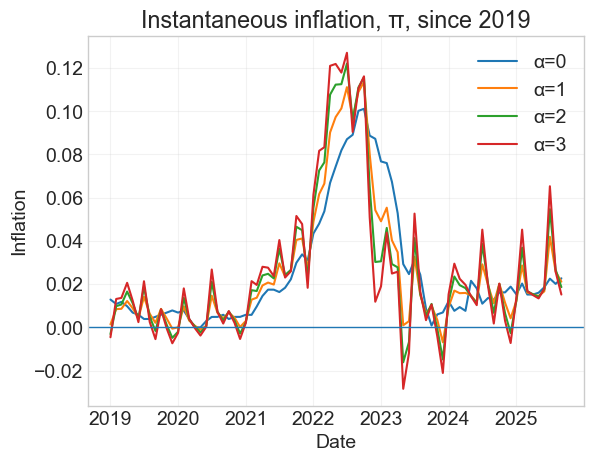

In [ ]:
# --- prep ---
priser = priser.sort_values('date').copy()
# monthly inflation: π_t = P_t/P_{t-1} - 1
priser['pi_t'] = priser['INDHOLD'].pct_change()


def kappa_weights(alpha, T=12):
    ks = np.arange(T)                   
    base = (T - ks)**alpha
    return (base / base.sum()) * T      


# The rolling method passes window as [oldest ... newest], but k=0 is newest,
# so we reverse the weights to align.
def inst_inflation_window(window, weights_rev):
    # window is a numpy array of length 12: oldest -> newest
    return np.prod((1.0 + window)**weights_rev) - 1

T = 12
alphas = [0, 1, 2, 3]
for a in alphas:
    w = kappa_weights(a, T=T)      
    w_rev = w[::-1]              
    col = f'pi12_a{a}'
    priser[col] = (
        priser['pi_t']
        .rolling(T)
        .apply(lambda x, wr=w_rev: inst_inflation_window(x, wr), raw=True)
    )

# plot since 2019
mask = priser['date'] >= pd.Timestamp('2019-01-01')
plt.figure()
for a in alphas:
    plt.plot(priser.loc[mask, 'date'], priser.loc[mask, f'pi12_a{a}'], label=f'α={a}')
plt.axhline(0, linewidth=1)
plt.title('Instantaneous inflation, π, since 2019')
plt.xlabel('Date'); plt.ylabel('Inflation')
plt.legend(); plt.grid(True)
plt.show()


# Semi conclusion to 1.2
we can also observe the standard yearly inflation rate from above but zoomed in freom 2019 and going forward:

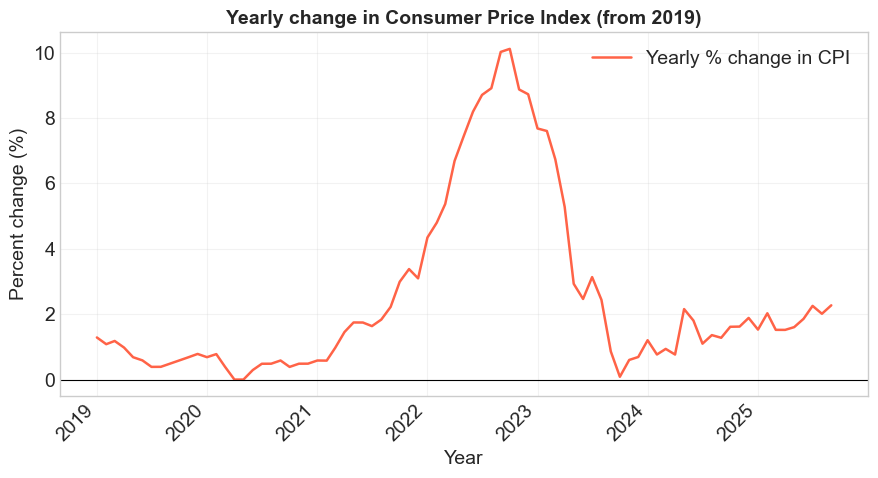

In [318]:
# Make a new figure with only data from 2019 onward
mask = priser["date"] >= pd.Timestamp("2019-01-01")

plt.figure(figsize=(9,5))
plt.plot(
    priser.loc[mask, "date"],
    priser.loc[mask, "pct_change"],
    color="tomato",
    linewidth=1.8,
    label="Yearly % change in CPI"
)

plt.title("Yearly change in Consumer Price Index (from 2019)", fontsize=14, weight="bold")
plt.xlabel("Year")
plt.ylabel("Percent change (%)")

plt.gca().xaxis.set_major_locator(mdates.YearLocator(1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
plt.xticks(rotation=45, ha="right")

plt.axhline(0, color="black", linewidth=0.8)
plt.legend()
plt.tight_layout()
plt.show()


# Full conclusion to 1.2
We can see that the standard yearly change in the CPI (which equals the instantaneous inflation for α = 0) reached its maximum later and was less severe, but it took longer to return to an inflation rate of zero. This is becuase the instantaneous inflation react quicker to changes.

# Core inflation 1.3